### фывфы

In [1]:
# std. imports
import numpy as np
import math as m
import matplotlib.pyplot as plt
import time
import timeit
%matplotlib inline
import numba as nb

figsizeConst = (11.6, 7.)
plt.rc('font', size=20)

## Уравнение КПП (Фишера)

In [9]:
xLeft = 0.
xRight = 10.
kappa = 0.2 # 0.1

In [43]:
@nb.jit(nopython=True, parallel=True)
def ReactionKPP(u):
    alpha = 5.0 # hardcoding
    R = 1.0 # hardcoding
    return alpha * u * (1 - u/R)


def InitialCondition(x):
    if x <= 1.0:
        return 1.
    else:
        return 0.


def SetInitialCondition(function, array, numPoints, h):
    for i in range(numPoints):
        array[i] = function(i * h)


@nb.jit(nopython=True, parallel=True)
def MakeStepScalar(uOld, numPoints, h, dt, kappa, uNew):
    courant = kappa * dt / (h * h)
    
    # явная реализация покоординатных операций с помощью цикла
    for i in nb.prange(1, numPoints - 1):
        uNew[i] = uOld[i] + courant * (uOld[i + 1] - 2 * uOld[i] + uOld[i - 1]) \
                  + dt*ReactionKPP(uOld[i])
    
    # boundaries
    uNew[0] = 1.
    uNew[-1] = 0.
    

@nb.jit(nopython=True, parallel=True)
def MakeStepVectorized(uOld, numPoints, h, dt, kappa, uNew):
    courant = kappa * dt / (h * h) 
    
    # неявная реализация поокоординатных операций с помощью векторизации
    uNew[1:numPoints-1] = uOld[1:numPoints-1] + courant*(uOld[2:numPoints] - 2*uOld[1:numPoints-1]\
                                                        + uOld[:numPoints-2])
    
    # reaction step
    uNew[1:numPoints-1] += dt * ReactionKPP(uOld[1:numPoints-1])

    # boundaries
    uNew[0] = 1.
    uNew[-1] = 0.
    

Calculations took ... 3.69e-01 s


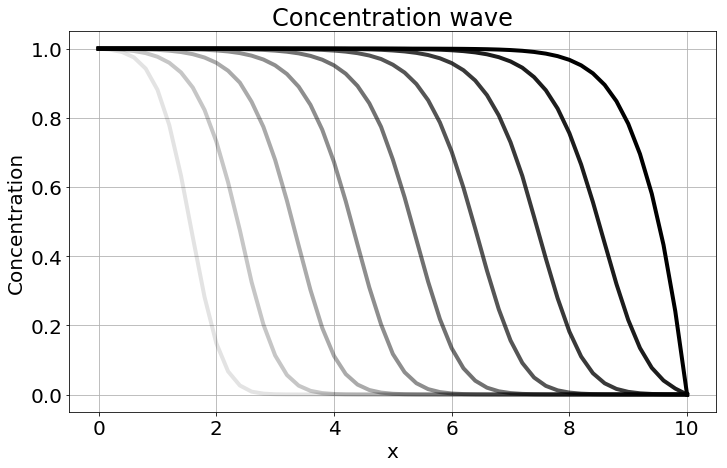

In [44]:
# main
counter = 0
counterOutput = 0
t, tRun = 0., 4.5 * 1e0
counterBlocks = 0
numBlocks = 50 #int(1e3)
numPoints = int(numBlocks + 1)
uOld, uNew = np.zeros(numPoints), np.zeros(numPoints)
h = float(xRight - xLeft) / float(numBlocks)
dt = h**2 / (kappa * 20.) # h**2 / (kappa * 20.)

                
start = timeit.default_timer()
SetInitialCondition(InitialCondition, uOld, numPoints, h)

# its essential to call plotting func before the timestepping
plt.figure(figsize=figsizeConst)
xArray = np.linspace(xLeft, xRight, numPoints)
plt.title('Concentration wave')
#plt.plot(xArray, uNew, 'b-', linewidth=4)
plt.xlabel('x')
plt.ylabel('Concentration')
plt.grid('on')

while t < tRun:
    
    # закомментироапть одну версию функции - раскомментировать другую
    MakeStepScalar(uOld, numPoints, h, dt, kappa, uNew)
    #MakeStepVectorized(uOld, numPoints, h, dt, kappa, uNew)
    
    uOld = uNew
    t += dt; counter += 1
    
    if (counter % int(5e1)) == 0:
        #print ('Step #%d' % counter)
        counterOutput += 1
        plt.plot(xArray, uOld, 'k-', linewidth=4, alpha=counterOutput/9.) # 9 --- 9 plots in total


end = timeit.default_timer()
runtime = end - start
print ('Calculations took ... %.2e s' % runtime)


'''
xArray = np.linspace(xLeft, xRight, numPoints)
plt.figure(figsize=figsizeConst)
plt.title('Numerical solution')
plt.plot(xArray, uNew, 'b-', linewidth=4)
plt.xlabel('x')
plt.ylabel('Temperature')
plt.grid('on')'''
plt.show()